In [1]:
import tensorflow as tf

import os
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

In [2]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100
EPOCHS = 150
PATH = './imagedata/'

In [3]:
def load(image_file):
    image_A = tf.io.read_file(image_file)
    image_A = tf.image.decode_png(image_A)

    image_B = tf.io.read_file(image_file)
    image_B = tf.image.decode_png(image_B)

    w_A = tf.shape(image_A)[1]
    w_B = tf.shape(image_B)[1]

    #w = w // 2
    #real_image = image[:, :w, :]
    #input_image = image[:, w:, :]

    image_A = tf.cast(image_A, tf.float32)
    image_B = tf.cast(image_B, tf.float32)

    return image_A, image_B

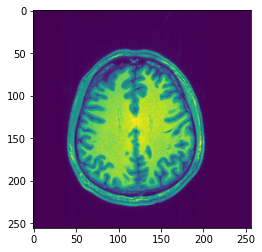

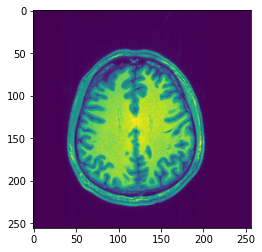

In [4]:
image_A, image_B = load(PATH + 'A/' + str(1) + '.png')
#image_B = load(PATH + 'B/' + str(1) + '.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(image_A/255.0)
plt.figure()
plt.imshow(image_B/255.0)

In [5]:
# normalizing the images to [-1, 1]

def normalize(image_A, image_B):
    image_A = (image_A / 127.5) - 1
    image_B = (image_B / 127.5) - 1

    return image_A, image_B

In [6]:
def load_image_train(image_file):
    image_A, image_B = load(image_file)
    #image_A, image_B = random_jitter(image_A, image_B)
    image_A, image_B = normalize(image_A, image_B)

    return image_A, image_B

In [7]:
train_dataset = tf.data.Dataset.list_files(PATH + '*/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [8]:
test_dataset = tf.data.Dataset.list_files(PATH + '*/*.png')
test_dataset = test_dataset.map(load_image_train) #was load_image_test
test_dataset = test_dataset.batch(BATCH_SIZE)

In [40]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False)
    )

    if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [10]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(image_A, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [12]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [13]:
def Generator():
    # ValueError: Input 0 of layer sequential_26 is incompatible with the layer:
    # expected axis -1 of input shape to have value 3 but received input with shape (1, 256, 256, 1)
    #inputs = tf.keras.layers.Input(shape=[256,256,3])
    inputs = tf.keras.layers.Input(shape=[256,256,1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

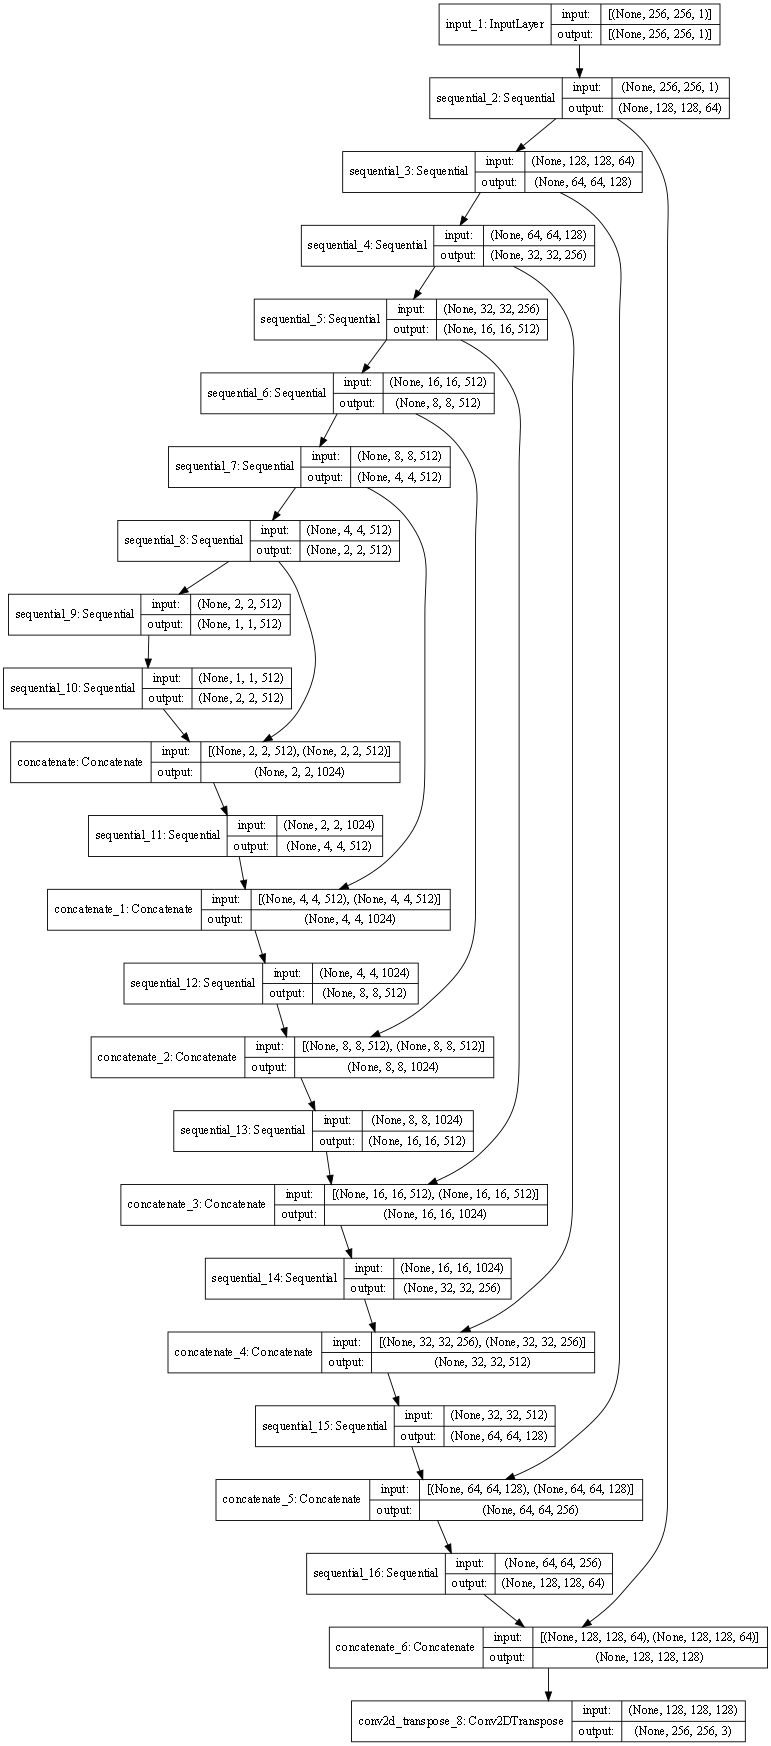

In [14]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


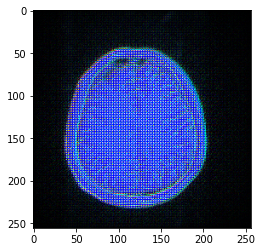

In [15]:
gen_output = generator(image_A[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [41]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # ValueError: Input 0 of layer sequential_56 is incompatible with the layer:
    # expected axis -1 of input shape to have value 6 but received input with shape (1, 256, 256, 4)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='image_A')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='image_B')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


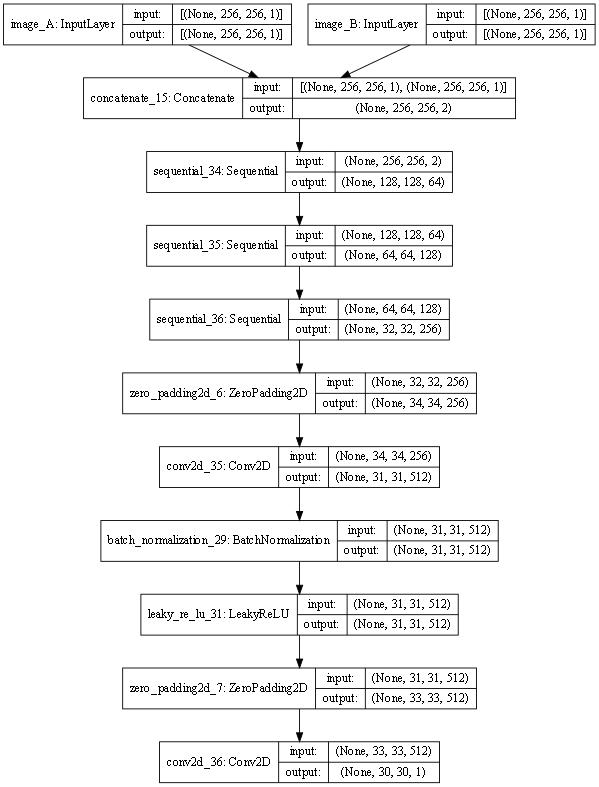

In [42]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [43]:
disc_out = discriminator([image_A[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

ValueError: Input 0 of layer sequential_34 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (1, 256, 256, 4)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [ ]:
log_dir = 'logs/'

summary_writer = tf.summary.create_file_writer(
    log_dir + 'fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
)